# Upload model with pretrained weights

In [ ]:
!pip install librosa

In [ ]:
!pip install --upgrade efficientnet-pytorch

In [ ]:
from google.colab import files
files.upload()

Saving model.pt to model.pt


In [ ]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

from efficientnet_pytorch import EfficientNet
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import cv2

# from waves to spectrograms
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=11)
model = model.to(device)
model.load_state_dict(torch.load('model.pt', map_location='cpu'))
model.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

# Record audio

In [ ]:
#https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import time

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1, path_to_save= "/content/"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  fn = str(time.time()) + ".wav"
  audio.export(path_to_save + fn, format="wav")
  return fn, audio

In [ ]:
filename, play = record()
print(filename); play


<IPython.core.display.Javascript object>

1638423178.179921.wav


# Prediction

tensor([[-2.2256, -2.3914,  1.1498,  3.8392,  0.4645,  0.0471, -1.8206, -0.9477,
         -2.1603, -2.2437,  2.4706]], grad_fn=<AddmmBackward0>)
up


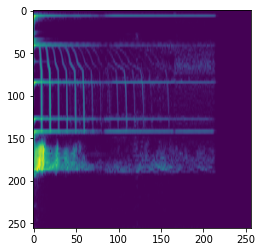

In [ ]:
# Get prediction
labels = ["go", "off", "stop", "up", "no", "right", "down", "left", "on", "yes", "bed"]

path_to_file = "/content/" + filename
samples, sample_rate = librosa.load(path_to_file, mono=True, sr=None)
freqs, times, spectrogram = log_specgram(samples, sample_rate)
img = cv2.resize(spectrogram, (256, 256))
img_rgb = np.stack((img,)*3, axis=-1).astype(np.float32())
plt.imshow(img)

aug = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])

new_tensor = aug(img_rgb)


output = model(new_tensor.unsqueeze(0).to(device))
print(output)
_, prediction = torch.max(output.data, 1)
print(labels[int(prediction)])
play